Code implementation for ResNets (He et al.: Deep Residual Learning for Image Recognition):

sourceL https://arxiv.org/pdf/1512.03385.pdf

# Setup

In [1]:
!pip install -Uqq fastbook >./tmp
import fastbook
fastbook.setup_book()

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
Mounted at /content/gdrive


In [2]:
from fastbook import *

#Data

In [3]:
url=URLs.CIFAR
presize=32
resize=28

In [4]:
path=untar_data(url)
Path.BASE_URL=path

path.ls()

(#3) [Path('/root/.fastai/data/cifar10/train'),Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/test')]

In [5]:
(path/'train').ls()

(#10) [Path('/root/.fastai/data/cifar10/train/truck'),Path('/root/.fastai/data/cifar10/train/dog'),Path('/root/.fastai/data/cifar10/train/frog'),Path('/root/.fastai/data/cifar10/train/cat'),Path('/root/.fastai/data/cifar10/train/ship'),Path('/root/.fastai/data/cifar10/train/horse'),Path('/root/.fastai/data/cifar10/train/deer'),Path('/root/.fastai/data/cifar10/train/airplane'),Path('/root/.fastai/data/cifar10/train/bird'),Path('/root/.fastai/data/cifar10/train/automobile')]

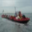

In [6]:
Image.open(get_image_files(path/'train/ship')[0])

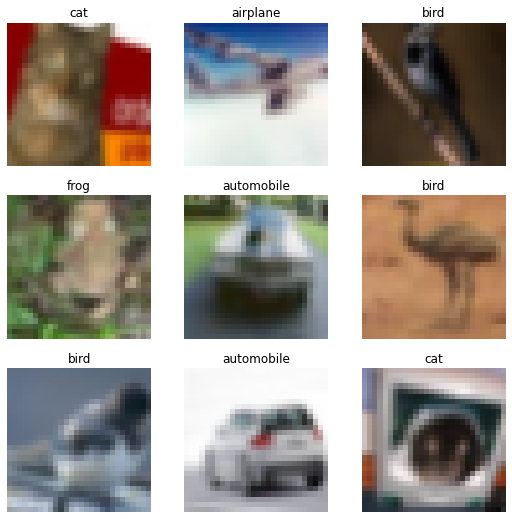

In [7]:
dls=DataBlock(blocks=(ImageBlock,CategoryBlock),
              splitter=GrandparentSplitter(valid_name='test'),
              get_items=get_image_files,
              get_y=parent_label,
              item_tfms=Resize(presize),
              batch_tfms=[*aug_transforms(min_scale=0.5,size=resize),Normalize.from_stats(*imagenet_stats)]
              ).dataloaders(path,bs=1024)

dls.show_batch()

In [8]:
dls.one_batch()[0].shape

torch.Size([1024, 3, 28, 28])

In [9]:
def avg_pool(x): return x.mean((2,3))

# Model - ResNet

![](https://drive.google.com/uc?id=1kPcWT39iKqlx5h2sm78Ab2UsQmQNpi5z)

In [10]:
# def _conv_block(ni,nf,stride):
#     return nn.Sequential(
#         ConvLayer(ni,nf,stride=stride),
#         ConvLayer(nf,nf,act_cls=None,norm_type=NormType.BatchZero)) #relu removed from here, and 

def _conv_block(ni,nf,stride): #BOTTLENECK ARCHITECTURES DEFINED BY THE AUTHORS
    return nn.Sequential(
        ConvLayer(ni,nf//4,1),
        ConvLayer(nf//4,nf//4,stride=stride),
        ConvLayer(nf//4,nf,1,act_cls=None, norm_type=NormType.BatchZero))
    
class ResBlock(Module):
    def __init__(self,ni,nf,stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni,nf,1,act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2,ceil_mode=True)
    
    def forward(self,x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x))) #note: ReLU after the entire layer

def block(ni,nf): return ResBlock(ni,nf,stride=2)

In [11]:
def _resnet_stem(*sizes): #stem is the first few layers of the CNN
    return [ConvLayer(sizes[i],sizes[i+1],3,stride=2 if i==0 else 1)
            for i in range(len(sizes)-1)] +[
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)]

In [12]:
class ResNet(nn.Sequential):
    def __init__(self,n_out,layers,expansion=1):
        stem=_resnet_stem(3,32,32,64)
        self.block_szs=[64,64,128,256,512]
        for i in range(1,len(self.block_szs)): self.block_szs[i]*=expansion
        blocks=[self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem,*blocks,
                       nn.AdaptiveAvgPool2d(1),Flatten(),
                       nn.Linear(self.block_szs[-1],n_out))
        
    def _make_layer(self,idx,n_layers):
        stride=1 if idx==0 else 2
        c_in, c_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[ResBlock(c_in if i==0 else c_out, c_out,stride if i==0 else 1)
                             for i in range(n_layers)])

resnet50

In [13]:
resnet50_=ResNet(dls.c,layers=[3, 4, 6, 3])

In [106]:
learn=cnn_learner(dls,resnet50, pretrained=False, loss_func=nn.CrossEntropyLoss(),metrics=[accuracy,partial(top_k_accuracy,k=3),partial(top_k_accuracy,k=5)]).to_fp16()
learn.summary()

Sequential (Input shape: 1024)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 64 x 14 x 14 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
____________________________________________________________________________
                     1024 x 256 x 7 x 7  
Conv2d                                    16384      True      
BatchNorm2d                               512        True      
ReLU                                                           
________________________________________

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.010964781977236271)

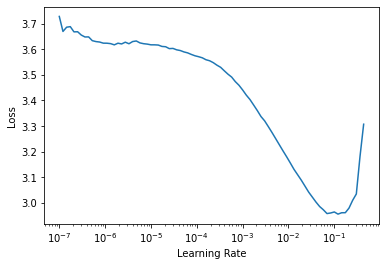

In [107]:
learn.lr_find()

Results from paper?

![](https://drive.google.com/uc?id=1tCrOtolmcqGGubfviQ6RhOri_Og3dvIp)

In [108]:
learn.fit_one_cycle(30,3e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.445264,1.995285,0.309900,0.655900,0.824100,01:11


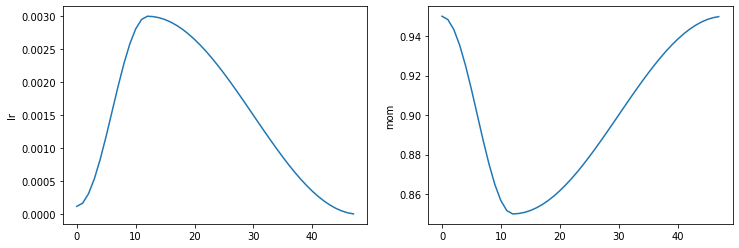

In [109]:
learn.recorder.plot_sched()

In [18]:
learner_acc = learn.recorder.values

In [54]:
training_loss=[i[0] for i in learner_acc]
valid_loss=[i[1] for i in learner_acc]
acc=[i[2] for i in learner_acc]
acc_top3=[i[3] for i in learner_acc]
acc_top5=[i[4] for i in learner_acc]

Text(0.5, 1.0, 'Accuracies')

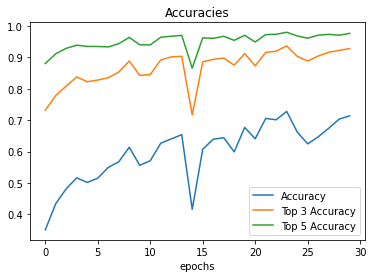

In [84]:
plt.plot([i[2] for i in learner_acc])
plt.plot([i[3] for i in learner_acc])
plt.plot([i[4] for i in learner_acc])
plt.legend(['Accuracy','Top 3 Accuracy','Top 5 Accuracy'])
plt.xlabel('epochs')
plt.title('Accuracies')

Text(0.5, 0, 'epochs')

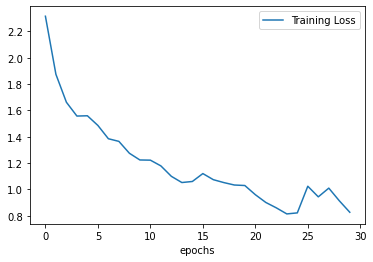

In [85]:
plt.plot([i[0] for i in learner_acc])
# plt.plot([i[1] for i in learner_acc])
plt.legend(['Training Loss'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

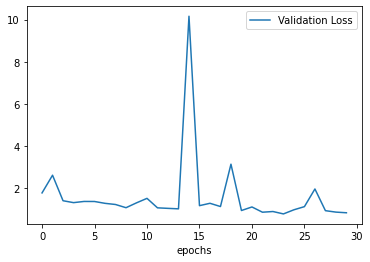

In [86]:
plt.plot([i[1] for i in learner_acc])
plt.legend(['Validation Loss'])
plt.xlabel('epochs')

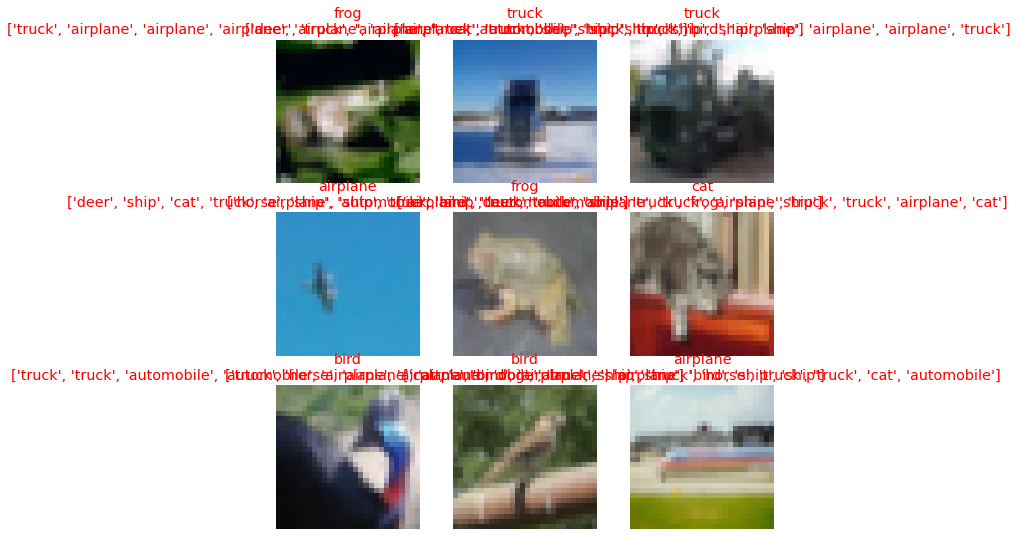

In [ ]:
#show this in final presentation
learn.show_results()

# Genetic Algorithm implementation

![](https://drive.google.com/uc?id=1DkQdy_xDPR2F2JjjlFuYaTRWfBrudgVv)

In [ ]:
import numpy as np
from numpy.random import randint
from random import random as rnd
from random import gauss, randrange

In [ ]:
# def individual(number_of_genes, upper_limit, lower_limit):
#     individual=[round(rnd()*(upper_limit-lower_limit)
#                 +lower_limit,1) for x in range(number_of_genes)]
#     return individual 

def individual(number_of_genes,limit):
    return [round(rnd()*(limit[i][1] -limit[i][0]) + limit[i][0],1) for i in range(number_of_genes)]

In [ ]:
#change this for individual limits
def population(number_of_individuals, number_of_genes, limits):
    return [individual(number_of_genes, limits) for x in range(number_of_individuals)]

In [ ]:
#change 
def fitness_calculation(individual):
    # fitness_value = sum(individual)
    learn=cnn_learner(dls,resnet50, pretrained=False, loss_func=nn.CrossEntropyLoss(),metrics=[accuracy,partial(top_k_accuracy,k=3),partial(top_k_accuracy,k=5)])
    learn.fit(n_epoch=int(individual[0]),lr=individual[1],wd=individual[2])
    # learn.fit(n_epoch=1,lr=individual[1],wd=individual[2])
    return learn.recorder.values[-1][2]#return the finally accuracy


In [ ]:
def selection(generation, method='Fittest Half'):
    generation['Normalized Fitness'] = \
        sorted([generation['Fitness'][x]/sum(generation['Fitness']) 
        for x in range(len(generation['Fitness']))], reverse = True)
    generation['Cumulative Sum'] = np.array(
        generation['Normalized Fitness']).cumsum()
    if method == 'Roulette Wheel':
        selected = []
        for x in range(len(generation['Individuals'])//2):
            selected.append(roulette(generation
                ['Cumulative Sum'], rnd()))
            while len(set(selected)) != len(selected):
                selected[x] = \
                    (roulette(generation['Cumulative Sum'], rnd()))
        selected = {'Individuals': 
            [generation['Individuals'][int(selected[x])]
                for x in range(len(generation['Individuals'])//2)]
                ,'Fitness': [generation['Fitness'][int(selected[x])]
                for x in range(
                    len(generation['Individuals'])//2)]}
    elif method == 'Fittest Half':
        selected_individuals = [generation['Individuals'][-x-1]
            for x in range(int(len(generation['Individuals'])//2))]
        selected_fitnesses = [generation['Fitness'][-x-1]
            for x in range(int(len(generation['Individuals'])//2))]
        selected = {'Individuals': selected_individuals,
                    'Fitness': selected_fitnesses}
    elif method == 'Random':
        selected_individuals = \
            [generation['Individuals']
                [randint(1,len(generation['Fitness']))]
            for x in range(int(len(generation['Individuals'])//2))]
        selected_fitnesses = [generation['Fitness'][-x-1]
            for x in range(int(len(generation['Individuals'])//2))]
        selected = {'Individuals': selected_individuals,
                    'Fitness': selected_fitnesses}
    return selected

In [ ]:
def pairing(elit, selected, method = 'Fittest'):
    individuals = [elit['Individuals']]+selected['Individuals']
    fitness = [elit['Fitness']]+selected['Fitness']
    if method == 'Fittest':
        parents = [[individuals[x],individuals[x+1]] 
                   for x in range(len(individuals)//2)]
    if method == 'Random':
        parents = []
        for x in range(len(individuals)//2):
            parents.append(
                [individuals[randint(0,(len(individuals)-1))],
                 individuals[randint(0,(len(individuals)-1))]])
            while parents[x][0] == parents[x][1]:
                parents[x][1] = individuals[
                    randint(0,(len(individuals)-1))]
    if method == 'Weighted Random':
        normalized_fitness = sorted(
            [fitness[x] /sum(fitness) 
             for x in range(len(individuals)//2)], reverse = True)
        cummulitive_sum = np.array(normalized_fitness).cumsum()
        parents = []
        for x in range(len(individuals)//2):
            parents.append(
                [individuals[roulette(cummulitive_sum,rnd())],
                 individuals[roulette(cummulitive_sum,rnd())]])
            while parents[x][0] == parents[x][1]:
                parents[x][1] = individuals[
                    roulette(cummulitive_sum,rnd())]
    return parents

In [ ]:
def mating(parents, method='Single Point'):
    if method == 'Single Point':
        pivot_point = randint(1, len(parents[0]))
        offsprings = [parents[0] \
            [0:pivot_point]+parents[1][pivot_point:]]
        offsprings.append(parents[1]
            [0:pivot_point]+parents[0][pivot_point:])
    if method == 'Two Pionts':
        pivot_point_1 = randint(1, len(parents[0]-1))
        pivot_point_2 = randint(1, len(parents[0]))
        while pivot_point_2<pivot_point_1:
            pivot_point_2 = randint(1, len(parents[0]))
        offsprings = [parents[0][0:pivot_point_1]+
            parents[1][pivot_point_1:pivot_point_2]+
            [parents[0][pivot_point_2:]]]
        offsprings.append([parents[1][0:pivot_point_1]+
            parents[0][pivot_point_1:pivot_point_2]+
            [parents[1][pivot_point_2:]]])
    return offsprings


In [ ]:
def mutation(individual, limits, muatation_rate=2, method='Reset', standard_deviation = 0.001):
    # lower_limit,upper_limit=limits
    # gene = [randint(0, 2)]
    gene=randint(0,3)
    lower_limit,upper_limit=limits[gene]
    # for x in range(muatation_rate-1):
    #     gene.append(randint(0, 7))
    #     while len(set(gene)) < len(gene):
    #         gene[x] = randint(0, 7)
    mutated_individual = individual.copy()
    # if method == 'Gauss':
    #     for x in range(muatation_rate):
    #         mutated_individual[x] = round(individual[x]+gauss(0, standard_deviation), 1)
    # if method == 'Reset':
    #     for x in range(muatation_rate):
    mutated_individual[gene] = round(rnd()* (upper_limit-lower_limit)+lower_limit,1)
    return mutated_individual

In [ ]:
def next_generation(gen, limits):
    elit = {}
    next_gen = {}
    elit['Individuals'] = gen['Individuals'].pop(-1)
    elit['Fitness'] = gen['Fitness'].pop(-1)
    selected = selection(gen)
    parents = pairing(elit, selected)
    offsprings = [[[mating(parents[x]) for x in range(len(parents))][y][z] for z in range(2)] for y in range(len(parents))]
    offsprings1 = [offsprings[x][0] for x in range(len(parents))]
    offsprings2 = [offsprings[x][1] for x in range(len(parents))]

    unmutated = selected['Individuals']+offsprings1+offsprings2
    mutated = [mutation(unmutated[x], limits) for x in range(len(gen['Individuals']))]
    # print(mutated)

    unsorted_individuals = mutated + [elit['Individuals']]
    unsorted_next_gen = [fitness_calculation(mutated[x]) for x in range(len(mutated))]
    unsorted_fitness = [unsorted_next_gen[x] for x in range(len(gen['Fitness']))] + [elit['Fitness']]
    sorted_next_gen = sorted([[unsorted_individuals[x], unsorted_fitness[x]] for x in range(len(unsorted_individuals))], key=lambda x: x[1])
    
    next_gen['Individuals'] = [sorted_next_gen[x][0] for x in range(len(sorted_next_gen))]
    next_gen['Fitness'] = [sorted_next_gen[x][1] for x in range(len(sorted_next_gen))]
    gen['Individuals'].append(elit['Individuals'])
    gen['Fitness'].append(elit['Fitness'])
    
    return next_gen

In [ ]:
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = False
    similarity = 0
    for n in range(len(max_fitness)-1):
        if max_fitness[n] == max_fitness[n+1]:
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = True
    return result

In [ ]:
# Generations and fitness values will be written to this file
# Result_file = 'GA_Results.txt'
# Creating the First Generation
def first_generation(pop):
    fitness = [fitness_calculation(pop[x]) for x in range(len(pop))]
    sorted_fitness = sorted([[pop[x], fitness[x]] for x in range(len(pop))], key=lambda x: x[1])
    population = [sorted_fitness[x][0] for x in range(len(sorted_fitness))]
    fitness = [sorted_fitness[x][1] for x in range(len(sorted_fitness))]
    return {'Individuals': population, 'Fitness': sorted(fitness)} #ascending order
    #do you need sorted in last line (return line)?

In [30]:
learner_accs={k: None for k in range(5)}

In [29]:
lrs=[1e-4 + ((1e-2 - 1e-4)/4)*i for i in range(5)]
lrs

[0.0001, 0.002575, 0.005050000000000001, 0.007525000000000001, 0.01]

In [31]:
for i in range(5):
    learn=cnn_learner(dls,resnet50, pretrained=False, loss_func=nn.CrossEntropyLoss(),metrics=[accuracy,partial(top_k_accuracy,k=3),partial(top_k_accuracy,k=5)]).to_fp16()
    learn.fit(30,lrs[i])
    learner_accs[i]=learn.recorder.values
    del learn

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,3.174082,2.390052,0.178300,0.454800,0.661600,01:07
1,2.831585,2.625239,0.195500,0.494400,0.703000,01:07
2,2.600046,2.318820,0.229000,0.542300,0.745300,01:07
3,2.441967,2.216793,0.247600,0.576800,0.767900,01:07
4,2.298568,2.032924,0.270600,0.603200,0.792100,01:07
5,2.191947,2.142855,0.283600,0.606600,0.792900,01:07
6,2.112926,1.991321,0.301500,0.633700,0.810300,01:07
7,2.050912,1.962757,0.320000,0.659500,0.828900,01:07
8,1.995319,1.888709,0.335900,0.670500,0.835000,01:07
9,1.940752,1.845038,0.347400,0.692100,0.850100,01:07


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.358490,2.085058,0.262900,0.619300,0.824200,01:06
1,1.896298,1.633961,0.441300,0.774600,0.899100,01:06
2,1.692706,1.489523,0.462500,0.790700,0.917600,01:07
3,1.623710,1.681192,0.441100,0.778500,0.909500,01:08
4,1.555007,1.423041,0.506500,0.822500,0.929600,01:08
5,1.473668,1.465536,0.471500,0.807300,0.925000,01:08
6,1.390416,1.261412,0.544700,0.846100,0.942200,01:07
7,1.376876,1.261529,0.552000,0.842400,0.943300,01:07
8,1.360112,3.417168,0.368000,0.718000,0.855800,01:06
9,1.356299,1.246473,0.553500,0.853600,0.946200,01:07


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.228199,1.927238,0.318600,0.628200,0.835400,01:08
1,1.829810,1.612859,0.446800,0.784100,0.916600,01:08
2,1.656121,1.430407,0.475600,0.806800,0.923900,01:08
3,1.599831,18.530054,0.332900,0.667600,0.826100,01:08
4,1.516561,1.466816,0.518800,0.832400,0.933300,01:07
5,1.476647,1.312230,0.535800,0.842800,0.940600,01:06
6,1.383720,1.258374,0.557200,0.850100,0.942300,01:06
7,1.319469,1.481218,0.497500,0.791700,0.911400,01:07
8,1.303192,1.170974,0.580800,0.870000,0.954000,01:06
9,1.211816,1.144383,0.617200,0.885500,0.961500,01:06


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.381896,1.999427,0.289800,0.665200,0.848400,01:06
1,1.955751,1.631842,0.408100,0.745300,0.887300,01:06
2,1.855216,1.781938,0.346300,0.680200,0.847800,01:06
3,1.831769,1.741636,0.374400,0.701000,0.855200,01:06
4,1.764667,1.715141,0.386500,0.735000,0.880300,01:07
5,1.679061,2.404809,0.383600,0.724700,0.862300,01:06
6,1.621008,1.425777,0.484300,0.807700,0.930500,01:06
7,1.572337,1.674189,0.400000,0.717900,0.875200,01:06
8,1.578085,1.885217,0.406600,0.750200,0.899500,01:06
9,1.583188,1.488064,0.462400,0.799000,0.920800,01:06


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,top_k_accuracy,time
0,2.370322,2.152214,0.248200,0.655800,0.837100,01:06
1,1.961964,4.459603,0.199700,0.477900,0.679700,01:06
2,1.855021,1.924466,0.319900,0.647900,0.812600,01:07
3,1.955152,3.919611,0.260800,0.622700,0.817800,01:07
4,1.857121,2.142437,0.375700,0.728400,0.883300,01:09
5,1.803241,1.744388,0.357700,0.711200,0.854500,01:08
6,1.767200,3.730920,0.315300,0.656100,0.814900,01:07
7,1.736231,1.591744,0.418400,0.766600,0.905600,01:07
8,1.632148,1.537318,0.438900,0.787400,0.914800,01:07
9,1.559473,1.813084,0.379900,0.682400,0.836200,01:08


In [ ]:
##tmp
# population = lr,wd,mom
limits=[(1e-6,1e-2),(0,0.1),(0.1,1.5)]
pop = population(3,3,limits)
gen = []


gen.append(first_generation(pop))
fitness_avg = np.array([sum(gen[0]['Fitness'])/len(gen[0]['Fitness'])])
fitness_max = np.array([max(gen[0]['Fitness'])])

gens=10
for i in range(gens):
    print('Generation ',i+1)
    gen.append(next_generation(gen[-1],limits))
    for i in range(5):
    learn=cnn_learner(dls,resnet50, pretrained=False, loss_func=nn.CrossEntropyLoss(),metrics=[accuracy,partial(top_k_accuracy,k=3),partial(top_k_accuracy,k=5)]).to_fp16()
    learn.fit(30,lrs[i])
    learner_accs[i]=learn.recorder.values
    fitness_avg = np.append(fitness_avg, sum(gen[-1]['Fitness'])/len(gen[-1]['Fitness']))
    fitness_max = np.append(fitness_max, max(gen[-1]['Fitness']))

In [64]:
accs={i:[k[2] for k in learner_accs[i] ] for i in range(len(learner_accs))}
accs_top3={i:[k[3] for k in learner_accs[i] ] for i in range(len(learner_accs))}
accs_top5={i:[k[4] for k in learner_accs[i] ] for i in range(len(learner_accs))}

In [55]:
training_losses = {i:[k[0] for k in learner_accs[i] ] for i in range(len(learner_accs))}
val_losses = {i:[k[1] for k in learner_accs[i] ] for i in range(len(learner_accs))} 

def convert_nans_to_prev_vals(losses: dict):
    for loss in losses:
        for i,val in enumerate(losses[loss]): 
            if torch.isnan(tensor(val)): losses[loss][i]=losses[loss][i-1]
    return losses

training_losses= convert_nans_to_prev_vals(training_losses)
val_losses = convert_nans_to_prev_vals(val_losses)

In [75]:
labels=['without GA: lr 3e-3, wd 0.01, mom 0.99 ',
        'with GA: lr 1e-4, wd 0.01, mom 0.43',
        'with GA: lr 2.5e-3, wd 0.07, mom 0.82',
        'with GA: lr 5e-3, wd 0.04, mom 0.91',
        'with GA: lr 7.5e-3, wd 0.1, mom 0.76',
        'with GA: lr 1e-2, wd 0.06, mom 1.2']

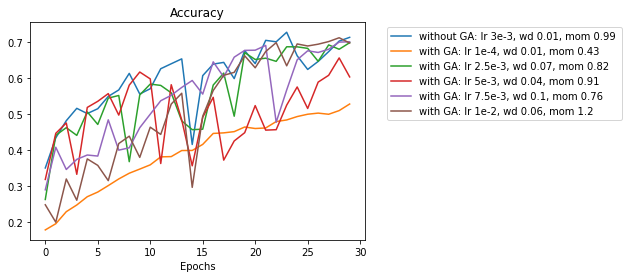

In [76]:
# plotting accuracy
plt.plot(acc,label=labels[0])
for i in accs:
    plt.plot(accs[i],label=labels[i+1])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel('Epochs')
plt.title('Accuracy');

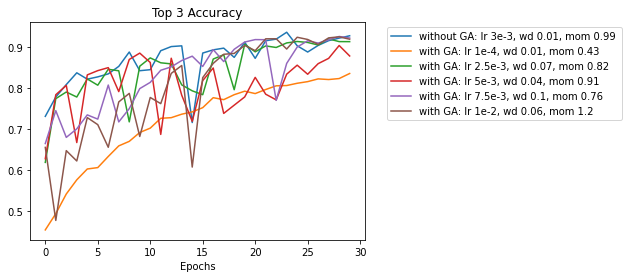

In [78]:
# plotting accuracy top3
plt.plot(acc_top3,label=labels[0])
for i in accs_top3:
    plt.plot(accs_top3[i],label=labels[i+1])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel('Epochs')
plt.title('Top 3 Accuracy');

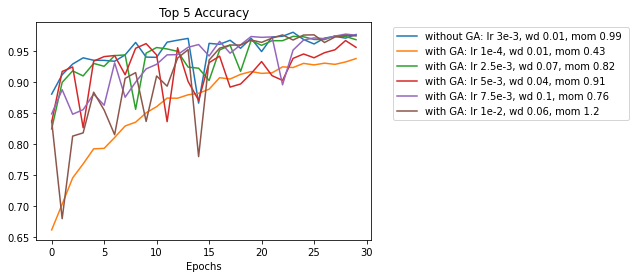

In [79]:
# plotting accuracy top5
plt.plot(acc_top5,label=labels[0])
for i in accs_top5:
    plt.plot(accs_top5[i],label=labels[i+1])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel('Epochs')
plt.title('Top 5 Accuracy');

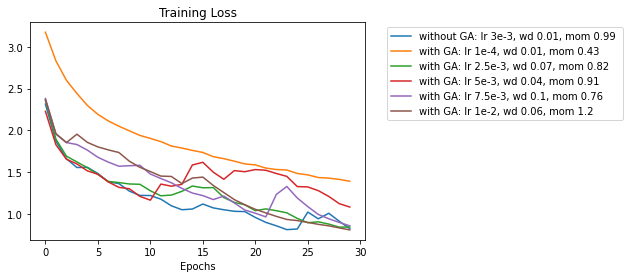

In [80]:
# plotting training losses
plt.plot(training_loss,label=labels[0])
for i in training_losses:
    plt.plot(training_losses[i],label=labels[i+1])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel('Epochs')
plt.title('Training Loss');

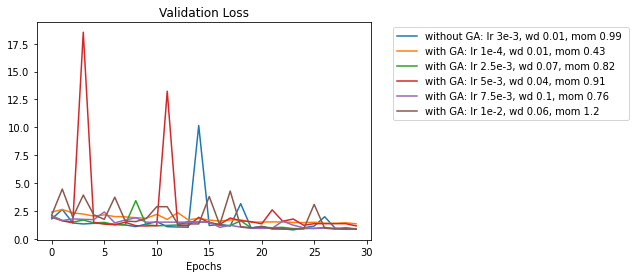

In [83]:
# plotting validation losses
plt.plot(valid_loss,label=labels[0])
for i in val_losses:
    plt.plot(val_losses[i],label=labels[i+1])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.xlabel('Epochs')
plt.title('Validation Loss');